### 1. Communicating with Coinbase Pro

First, we will create a simple class to communicate with https://api.pro.coinbase.com

In [5]:
import requests
import matplotlib
import pandas as pd
import time
import os
from datetime import datetime, timedelta

class CoinbasePro():

    def __init__(self):
        self.api_url = 'https://api.pro.coinbase.com'
        self.session = requests.Session()
        self.GRANULARITY = ['60', '300', '900', '3600', '21600', '86400'] # Desired timeslice in seconds
        self.timeout = 10
        
    def get_products(self):
        response = self.session.request(
        method='get',
        url= self.api_url + '/products',
        timeout=self.timeout,
        ).json()
        return response

    def get_candles(self, product, start, end, granularity=3):
        # return candlestick chart for product
        response = self.session.request(
            method='get',
            url= self.api_url + '/products/'+ product + '/candles',
            params={
                'start': start,
                'end': end,
                'granularity': self.GRANULARITY[granularity]
            },
            timeout=self.timeout
        ).json()
        df = pd.DataFrame(response)
        df.rename(
            columns={
                0: 'date',
                1: 'low',
                2: 'high',
                3: 'open',
                4: 'close',
                5: 'volume'
            },
            inplace=True
        )
        df['date'] = pd.to_datetime(df['date'],unit='s', utc=True)
        df.set_index('date', inplace=True)
        
        return df

cb = CoinbasePro()

Before we can do any analysis, we need to get the available trading pairs

In [6]:
products = cb.get_products()
products_df = pd.DataFrame(products)

products_df['id']

0      CVC-USDC
1       XLM-BTC
2       EOS-USD
3       LTC-GBP
4       ETC-BTC
5       XRP-EUR
6       XRP-BTC
7       LTC-EUR
8       ZEC-BTC
9     LOOM-USDC
10     DNT-USDC
11      BTC-GBP
12      XLM-EUR
13     ALGO-USD
14      BTC-EUR
15     BAT-USDC
16      ETH-EUR
17     DASH-USD
18     LINK-ETH
19      BCH-EUR
20      BCH-BTC
21      BTC-USD
22     DASH-BTC
23      ETH-USD
24      BCH-USD
25      XRP-USD
26      BAT-ETH
27      XTZ-USD
28     LINK-USD
29      ETC-GBP
30     DAI-USDC
31      ETH-BTC
32     ZEC-USDC
33     BTC-USDC
34      XLM-USD
35      ETH-GBP
36      LTC-BTC
37     ETH-USDC
38      ZRX-BTC
39     GNT-USDC
40    MANA-USDC
41      ZRX-EUR
42      ETC-USD
43      ZRX-USD
44      EOS-EUR
45      REP-BTC
46      ETC-EUR
47      XTZ-BTC
48      LTC-USD
49      REP-USD
50      BCH-GBP
51      ETH-DAI
52      EOS-BTC
Name: id, dtype: object

We can see there are a total of 53 available trading pairs. 

Let's get the charts for these pairs for the past 12 days. To save time, we'll save them as .CSV files.

First, we'll create the folder where we will save these files.

In [7]:
# select the end_date as current time, and the start_date as current time minus 12 days
date_range = datetime.now() - timedelta(days=12)
start_date = datetime.strptime(str(date_range), '%Y-%m-%d %H:%M:%S.%f').isoformat()
end_date = datetime.now().isoformat()

# get the current working directory
current_directory = os.getcwd() 
data_directory = current_directory + os.sep + 'charts_' + start_date[:-16] + '_' + end_date[:-16] + os.sep

#create the folder
try:
    os.mkdir(data_directory)
except FileExistsError:
    pass


Now we can populate the folder we created with 53 .CSV files.

In [54]:

# count the number of files in the data_directory
path, dirs, files = next(os.walk(data_directory))
file_count = len(files)

# only save the files if there aren't already 53 .csv files. 
if file_count < 53:
    for pair in products_df['id']:
        # get charts
        candles = cb.get_candles(pair, start_date, end_date,)
        file_name = data_directory + pair + '.csv'
        # save to CSV
        export_csv = candles.to_csv(file_name, header=True)
        print('saved: ' + pair + '.csv')
        
        # sleep so we don't make Coinbase angry
        time.sleep(0.55)

### 2. Finding Correlation Between Two Distinct Trading Pairs

Next, we will analyze the available currency pairs to find their correlations.

Let's start by finding the correlation of just two specific trading pairs: ETH-GBP and ETH-USD

In [55]:
ETH_BGP = pd.read_csv(data_directory + 'ETH-GBP.csv')
ETH_USD = pd.read_csv(data_directory + 'ETH-USD.csv')

ETH_BGP.corrwith(ETH_USD, axis = 0) 

low       0.999198
high      0.998101
open      0.998689
close     0.998824
volume    0.570074
dtype: float64

We can see that there is a fairly high correlation between the price movements of both of these trading pairs. On the other hand, there is a relatively low correlation in volume. 

### 3. Finding Correlations Between Price and Volume Movements of All Pairs

Next, we should look at the correlations of all pairs. To do this we will start by concatenating all trading pairs .CSV files into one large dataframe. Let's start by getting a list of paths in the folder we created.

In [56]:
path, dirs, files = next(os.walk(data_directory))
paths = [data_directory + file for file in files if True]

Now that we have all the necessary file paths, we can read them in as dataframes, and concatenate them to one large dataframe.

In [57]:
def concat_csvs(paths):
    dfs = []
    # read all files and append to big dataframe
    for count, path in enumerate(paths):
        df = pd.read_csv(path)
        # drop unnecessary columns
        df.drop(['date', 'low','high', 'open'], 1, inplace=True)
        # make names a bit more sensible
        df.rename(columns={'volume': files[count][:-4] + '(volume)'}, inplace=True)
        df.rename(columns={'close': files[count][:-4] + '(price)'}, inplace=True)
        dfs.append(df)
    # concatenate all dataframes
    return pd.concat(dfs, axis=1)

dfs = concat_csvs(paths)

With just a single line of code, we will calculate the linear correlation of price of two trading pairs, as well as the linear correlation of volume of those same trading pairs, for each of the 53 trading pairs on Coinbase Pro. 

In [58]:
dfs.corr()

BTC-GBP(price)  BTC-GBP(volume)  ETC-EUR(price)  \
BTC-GBP(price)          1.000000        -0.245853        0.862907   
BTC-GBP(volume)        -0.245853         1.000000       -0.120085   
ETC-EUR(price)          0.862907        -0.120085        1.000000   
ETC-EUR(volume)        -0.125793         0.011924       -0.144067   
ETH-USD(price)          0.955471        -0.215745        0.900813   
...                          ...              ...             ...   
EOS-USD(volume)        -0.129241         0.651578        0.078175   
ETH-USDC(price)         0.954111        -0.210760        0.898672   
ETH-USDC(volume)       -0.192549         0.658956       -0.098751   
ZRX-USD(price)          0.623993        -0.266305        0.374399   
ZRX-USD(volume)        -0.080990         0.477098        0.009171   

                  ETC-EUR(volume)  ETH-USD(price)  ETH-USD(volume)  \
BTC-GBP(price)          -0.125793        0.955471        -0.322552   
BTC-GBP(volume)          0.011924       -0.215745         0.828856   
ETC-EUR(price)          -0.144067        0.900813        -0.127142   
ETC-EUR(volume)          1.000000       -0.098035        -0.009091   
ETH-USD(price)          -0.098035        1.000000        -0.268116   
...                           ...             ...              ...   
EOS-USD(volume)         -0.023537       -0.080226         0.746193   
ETH-USDC(price)         -0.097729        0.999579        -0.264332   
ETH-USDC(volume)        -0.017864       -0.168914         0.738628   
ZRX-USD(price)          -0.161092        0.426685        -0.379776   
ZRX-USD(volume)         -0.029976       -0.034125         0.450673   

                  XRP-BTC(price)  XRP-BTC(volume)  LTC-GBP(price)  \
BTC-GBP(price)         -0.324455        -0.167582        0.918603   
BTC-GBP(volume)         0.221311         0.667628       -0.182590   
ETC-EUR(price)         -0.019919        -0.027619        0.899568   
ETC-EUR(volume)         0.169257        -0.031579       -0.081978   
ETH-USD(price)         -0.111817        -0.124792        0.985352   
...                          ...              ...             ...   
EOS-USD(volume)         0.309006         0.512229       -0.042387   
ETH-USDC(price)        -0.109122        -0.120873        0.984764   
ETH-USDC(volume)        0.180424         0.484441       -0.149796   
ZRX-USD(price)         -0.621995        -0.238076        0.341157   
ZRX-USD(volume)         0.204137         0.439178       -0.009056   

                  LTC-GBP(volume)  ...  ZRX-BTC(price)  ZRX-BTC(volume)  \
BTC-GBP(price)          -0.154251  ...       -0.437874        -0.032542   
BTC-GBP(volume)          0.127083  ...       -0.036757         0.319724   
ETC-EUR(price)          -0.110732  ...       -0.548159         0.048046   
ETC-EUR(volume)          0.104452  ...       -0.041947        -0.003100   
ETH-USD(price)          -0.128234  ...       -0.610370        -0.007519   
...                           ...  ...             ...              ...   
EOS-USD(volume)          0.064838  ...       -0.130795         0.232845   
ETH-USDC(price)         -0.127159  ...       -0.610638        -0.005736   
ETH-USDC(volume)         0.072277  ...       -0.051221         0.183478   
ZRX-USD(price)          -0.142134  ...        0.426316        -0.019452   
ZRX-USD(volume)          0.053936  ...       -0.049217         0.558322   

                  ETC-GBP(price)  ETC-GBP(volume)  EOS-USD(price)  \
BTC-GBP(price)          0.490136        -0.114238        0.966719   
BTC-GBP(volume)         0.164530        -0.083213       -0.239505   
ETC-EUR(price)          0.724877        -0.172441        0.896509   
ETC-EUR(volume)         0.073783         0.048415       -0.115573   
ETH-USD(price)          0.622347        -0.104663        0.986847   
...                          ...              ...             ...   
EOS-USD(volume)         0.286395        -0.078728       -0.122036   
ETH-USDC(price)         0.623452        -0.104389        0.986340 

### 4. Visualization of Pearson Correlation Matrix

Finally, we can create a visualization of the Pearson correlation matrix we created

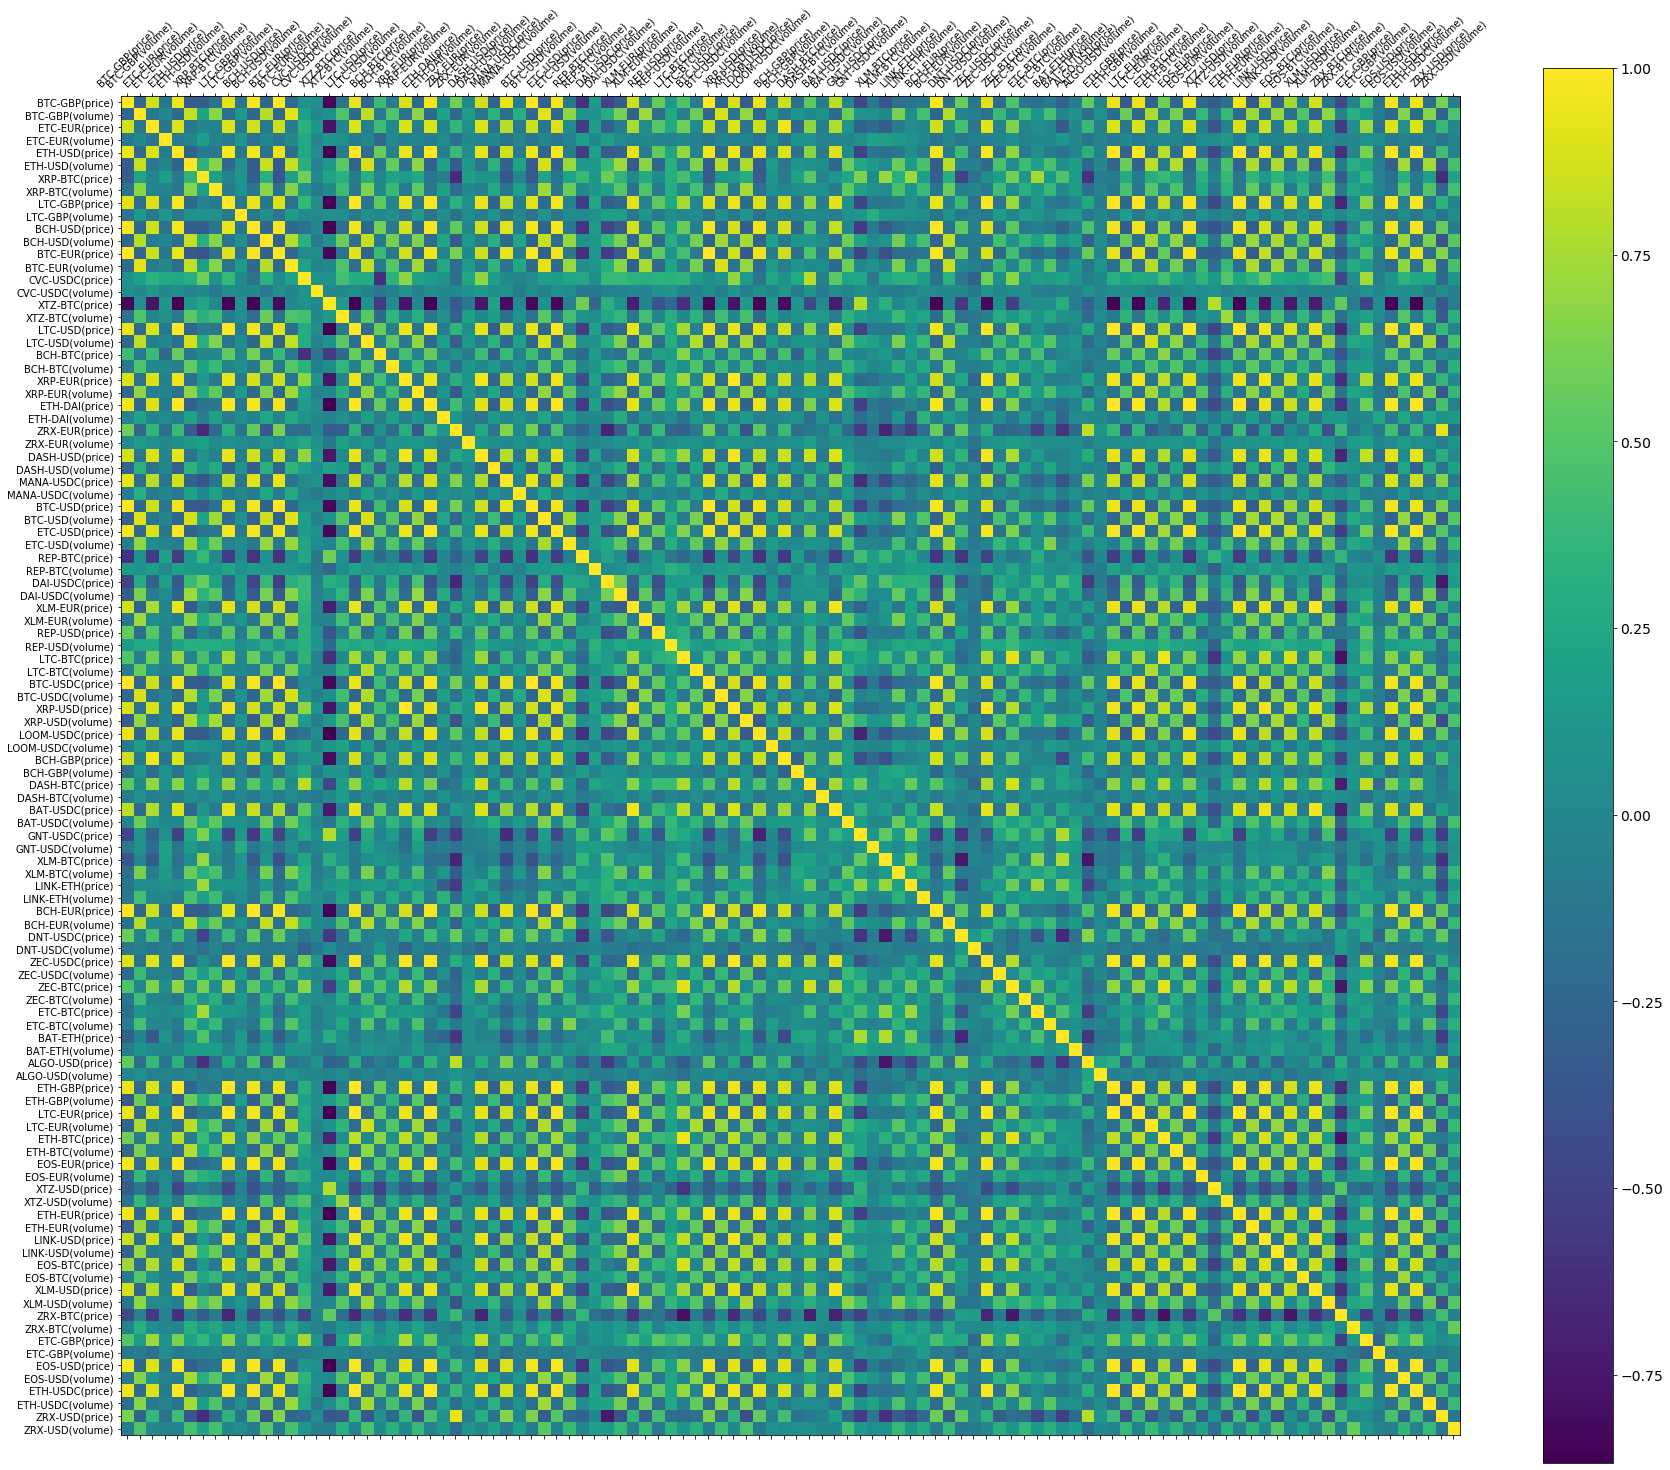

In [59]:
f = plt.figure(figsize=(30, 25))
plt.matshow(dfs.corr(), fignum=f.number)
plt.xticks(range(dfs.shape[1]), dfs.columns, fontsize=10, rotation=45)
plt.yticks(range(dfs.shape[1]), dfs.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

### 5. Conclusion

Now that we have found correlations between volume and price movements of certain pairs, we can use this data to create a trading strategy and define a portfolio. 

For example, if we want to create a diversified portfolio, we would want to choose pairs with low correlations. On the other hand, if we are creating a strategy such as a mean reversal strategy, we should find pairs with strong correlations, and monitor them for any deviation. 